In [55]:
import numpy as np
import matplotlib.pylab as plot
from astropy.io import ascii,fits
from scipy import interpolate
import grb_catalogs_copy
from BurstCube.LocSim.Detector import *
from BurstCube.LocSim.Spacecraft import *
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.optimize import curve_fit

In [56]:
# read in GBM GRB catalog (first 9 years)
gbm=fits.open('gbmgrbcat_copy.fits')
gbm=gbm[1].data

In [57]:
## read in GBM effective area curve
def getGBMdata(gbmfile=None):
    """Reads the GBM NaI effective area file and returns a numpy array
    with two columns ``energy`` and ``aeff``.
    Parameters
    ----------
    gbmfile : string
       Name of file that contains the GBM data.
    Returns
    ----------
    gbmdata : array 
    numpy array with two columns ``energy`` and ``aeff``
    """

    from numpy import genfromtxt
    from os import path

    gbmfile = path.expandvars(gbmfile)
    
    return np.genfromtxt(gbmfile,skip_header=6,names=('energy', 'aeff'))


In [58]:
## bit of useful code for interpolating in log space
def loginterpol(x,y,x1):

    f=interpolate.interp1d(np.log10(x),np.log10(y),bounds_error=False,fill_value="extrapolate",kind='linear')
    y1=10**f(np.log10(x1))

    return y1

def loginterpol2d(x,y,z,x1,y1):

    wz=np.where(z==0)[0]
    zz=z
    zz[wz]=1.
    f=interpolate.interp2d(x,y,np.log10(zz),bounds_error=False,fill_value="extrapolate",kind='linear')
    z1=10**f(x1,y1)

In [59]:
## generate random positions on the sky with equal area probability
def random_sky(n=1):

    u=np.random.rand(n)
    v=np.random.rand(n)

    phi=2*np.pi*u
    theta=np.arccos(2*v-1.)

    dec=-np.degrees(theta-np.pi/2.)
    ra=np.degrees(np.pi*2-phi)

    return ra,dec

In [60]:
## read in the GBM Aeff
aeff_gbm = getGBMdata('/home/alyson/nasa/Simulation/GEANT3/effarea_vs_e-15deg.dat')
## On line 4 and 5 of the file the titles do not fill the full 7 columns the program is searching for and therefore, we are getting an error
## I am going to try skipping 6 lines rather than skipping two in order to remove the full header. This worked
print(aeff_gbm) # this is just a test to see what we are getting when we get the GBM data

[(0.699   , 72.3219) (0.751397, 77.4358) (0.803794, 77.7857)
 (0.856191, 85.1105) (0.908587, 86.1907) (0.960984, 82.9639)
 (1.01338 , 85.6965) (1.06578 , 81.0764) (1.11817 , 82.5395)
 (1.17057 , 83.8759) (1.22297 , 85.4437) (1.27536 , 87.6594)
 (1.32776 , 86.3204) (1.38016 , 85.668 ) (1.43256 , 85.2695)
 (1.48495 , 87.3793) (1.53735 , 86.3757) (1.58975 , 87.2955)
 (1.64214 , 87.787 ) (1.69454 , 89.8048) (1.74694 , 89.4448)
 (1.79933 , 90.1976) (1.85173 , 90.2635) (1.90413 , 90.9586)
 (1.95652 , 89.9348) (2.00892 , 91.1565) (2.06132 , 91.333 )
 (2.11371 , 89.9316) (2.16611 , 89.0176) (2.21851 , 86.4648)
 (2.2709  , 82.0684) (2.3233  , 76.3423) (2.3757  , 70.0347)
 (2.42809 , 64.2853) (2.48049 , 59.7397) (2.53289 , 53.6716)
 (2.58528 , 49.0986) (2.63768 , 45.1992) (2.69008 , 41.7792)
 (2.74247 , 39.0813) (2.79487 , 36.6988) (2.84727 , 34.0019)
 (2.89966 , 32.5151) (2.95206 , 30.3944) (3.00446 , 29.2011)
 (3.05686 , 26.3996) (3.10925 , 25.8263) (3.16165 , 24.0471)
 (3.21405 , 22.8942) (3.

In [61]:
## separate GBM short & long GRBs
w=np.where(gbm['FLUX_1024']>0)
gbm=gbm[w]
s=np.where(gbm['T90'] <= 2.)[0]
l=np.where(gbm['T90'] > 2.)[0]
m=np.where(gbm['PFLX_BEST_FITTING_MODEL'][s] == ' ')

In [62]:
# duration of GBM data
duration=(max(gbm['TRIGGER_TIME'])-min(gbm['TRIGGER_TIME']))/365.25
print(duration,'years')

9.970877356449009 years


In [63]:
rate=len(s)/duration
print(rate,' short GRBs per year')
sflux=gbm['FLUX_1024'][s]
so=np.argsort(sflux)
sflux=sflux[so]
n20=int(np.round(20*duration))
#print 'photon flux limit for BurstCube to detection 20 sGRBs per year = ',sflux[n20]
#print np.min(sflux),np.max(sflux)

39.51507835417983  short GRBs per year


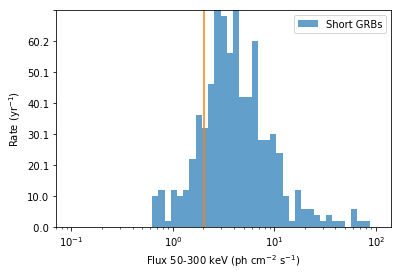

In [64]:
## plot 1s peak flux distributions - note that some are missing the spectral info, must use a template instead
##   also, most peak flux not measured on 1s timescale, but 64 ms
fig, ax1 = plot.subplots()
#ax1.hist(gbm['FLUX_1024'][l],bins=np.logspace(np.log10(0.1),np.log10(100.0), 50),label='Long GRBs')
ax1.hist(gbm['FLUX_BATSE_64'][s],bins=np.logspace(np.log10(0.1),np.log10(100.0), 50),alpha=0.7,label='Short GRBs')
plot.plot([sflux[n20],sflux[n20]],[0,500])
#ax1.hist(gbm['FLUX_1024'][s[m]],bins=np.logspace(np.log10(0.1),np.log10(100.0), 50),alpha=0.7,label='Short GRBs w/ spectra')
y_vals = ax1.get_yticks()
ax1.set_yticklabels(['{:4.1f}'.format(x / duration) for x in y_vals])
plot.ylim([0,35])
plot.xscale('log')
plot.xlabel(r'Flux 50-300 keV (ph cm$^{-2}$ s$^{-1}$)')
plot.ylabel(r'Rate (yr$^{-1}$)')
plot.legend()
plot.show()


# plot.figure()
# plot.hist(gbm['FLUX_1024'][l],bins=np.logspace(np.log10(0.1),np.log10(100.0), 50))
# plot.hist(gbm['FLUX_1024'][s],bins=np.logspace(np.log10(0.1),np.log10(100.0), 50),alpha=0.7)
# plot.hist(gbm['FLUX_1024'][s[m]],bins=np.logspace(np.log10(0.1),np.log10(100.0), 50),alpha=0.7)
# plot.xscale('log')
# plot.show()

In [65]:
## read in BurstCube Aeff for various BC configurations
file='/home/alyson/nasa/Simulation/BurstCube/Users/jracusin/BC_eff_area_curves.ecsv'
aeffs=ascii.read(file,format='ecsv')
aeffs

diameter,height,az,ze,keV,aeff,aeff_eres,aeff_eres_modfrac
float64,float64,float32,float32,float32,float32,float32,float32
90.0,22.0,0.0,0.0,50.0,55.8351,46.7395,54.6904
90.0,22.0,0.0,0.0,75.1462,59.8132,54.1071,58.5332
90.0,22.0,0.0,0.0,112.939,62.1697,58.054,60.4911
90.0,22.0,0.0,0.0,169.739,62.6373,58.1963,60.3699
90.0,22.0,0.0,0.0,255.105,56.0151,48.6771,49.7694
90.0,22.0,0.0,0.0,383.404,45.6845,32.5913,33.1395
90.0,22.0,0.0,0.0,576.227,36.94,20.04,20.3207
90.0,22.0,0.0,0.0,866.025,30.9237,12.487,25.042
90.0,22.0,0.0,0.0,1301.57,25.6741,7.79467,15.6125


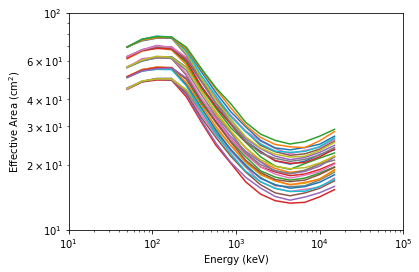

In [68]:
## grab short GRBs with peak spectral info & plot all of the Aeff curves
s=np.where((gbm['T90'] <= 2.) & (gbm['PFLX_BEST_FITTING_MODEL'] != ' '))[0]
eng=aeffs['keV']
engdiff=eng[1:]-eng[0:-1]
w=np.where(engdiff<0)[0]
nsims=len(w)
w=np.append(-1,w)#,len(eng))
for i in range(nsims):
    plot.plot(aeffs['keV'][w[i]+1:w[i+1]+1],aeffs['aeff'][w[i]+1:w[i+1]+1])
plot.xscale('log')
plot.yscale('log')
plot.xlabel('Energy (keV)')
plot.ylabel(r'Effective Area (cm$^2$)')
plot.plot(aeff_gbm['energy'],aeff_gbm['aeff'])
i=0
gbmae=loginterpol(aeff_gbm['energy'],aeff_gbm['aeff'],eng[w[i]+1:w[i+1]+1])
plot.plot(eng[w[i]+1:w[i+1]+1],gbmae)
plot.xlim([10,100000])
plot.ylim([10,100])
plot.show()
## This plot looks different than what Judy's notebook created. Possibly I am using the wrong data file

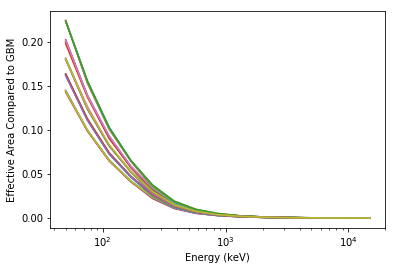

In [28]:
## plot ratio of BC Aeff to GBM Aeff
for i in range(nsims):
    gbmae=loginterpol(aeff_gbm['energy'],aeff_gbm['aeff'],eng[w[i]+1:w[i+1]+1])
    plot.plot(eng[w[i]+1:w[i+1]+1],aeffs['aeff'][w[i]+1:w[i+1]+1]/gbmae)
plot.xscale('log')
plot.xlabel('Energy (keV)')
plot.ylabel(r'Effective Area Compared to GBM')
plot.show()

In [29]:
## grab energies from those curves
E=np.array(eng[w[i]+1:w[i+1]+1])
print(E)

[   50.        75.1462   112.939    169.739    255.105    383.404
   576.227    866.025   1301.57    1956.16    2939.97    4418.55
  6640.74    9980.54   15000.    ]


In [30]:
## For each short GRB and each BC simulation, calculate peak flux integrating peak flux spectrum
##   Scale integrated peak flux by ratio of Aeff for that sim
mo=gbm['PFLX_BEST_FITTING_MODEL'][s]
f=np.zeros([len(s),nsims])
pf=np.zeros(len(s))
outE=np.logspace(np.log10(50),np.log10(300),20)
for i in range(len(s)):
    for j in range(nsims):
        E=np.array(eng[w[j]+1:w[j+1]+1])
        AeffBC=loginterpol(E,aeffs['aeff'][w[j]+1:w[j+1]+1],outE)
        AeffGBM=loginterpol(aeff_gbm['energy'],aeff_gbm['aeff'],outE)#eng[w[j]+1:w[j+1]+1])
        Aratio=np.sqrt(AeffBC/AeffGBM)
        if mo[i]=='PFLX_PLAW':
            f[i,j]=np.trapz(gbm['PFLX_PLAW_AMPL'][s[i]]*grb_catalogs_copy.pl(outE,gbm['PFLX_PLAW_INDEX'][s[i]])*Aratio,outE)
            pf[i]=gbm['PFLX_PLAW_PHTFLUX'][s[i]]
        if mo[i]=='PFLX_COMP':
            f[i,j]=np.trapz(gbm['PFLX_COMP_AMPL'][s[i]]*grb_catalogs_copy.comp(outE,gbm['PFLX_COMP_INDEX'][s[i]],gbm['PFLX_COMP_EPEAK'][s[i]])*Aratio,outE)
            pf[i]=gbm['PFLX_COMP_PHTFLUX'][s[i]]
        if mo[i]=='PFLX_BAND':
            f[i,j]=np.trapz(gbm['PFLX_BAND_AMPL'][s[i]]*grb_catalogs_copy.band(outE,gbm['PFLX_BAND_ALPHA'][s[i]],gbm['PFLX_BAND_EPEAK'][s[i]],gbm['PFLX_BAND_BETA'][s[i]])*Aratio,outE)
            pf[i]=gbm['PFLX_BAND_PHTFLUX'][s[i]]
        if mo[i]=='PFLX_SBPL':
            f[i,j]=np.trapz(gbm['PFLX_SBPL_AMPL'][s[i]]*grb_catalogs_copy.sbpl(outE,gbm['PFLX_SBPL_INDX1'][s[i]],gbm['PFLX_SBPL_BRKEN'][s[i]],gbm['PFLX_SBPL_INDX2'][s[i]])*Aratio,outE)
            pf[i]=gbm['PFLX_SBPL_PHTFLUX'][s[i]]
        

In [31]:
## setup BurstCube
pointings = {'01': ('0:0:0','45:0:0'),
           '02': ('90:0:0','45:0:0'),
           '03': ('180:0:0','45:0:0'),
           '04': ('270:0:0','45:0:0')}
spacecraft = Spacecraft(pointings,window=0.1)

res = 250
rr,dd = np.meshgrid(np.linspace(0,360,res,endpoint=False),np.linspace(-90,90,res))
exposure_positions = np.vstack([rr.ravel(),dd.ravel()])
exposures = np.array([[ detector.exposure(position[0],position[1]) for position in exposure_positions.T] 
                      for detector in spacecraft.detectors])

In [32]:
## setup GBM
gbm_pointings = {'01': ('45:54:0','20:36:0'),
            '02': ('45:6:0','45:18:0'),
            '03': ('58:24:0','90:12:0'),
            '04': ('314:54:0','45:12:0'),
            '05': ('303:12:0','90:18:0'),
            '06': ('3:24:0','89:48:0'),
            '07': ('224:54:0','20:24:0'),
            '08': ('224:36:0','46:12:0'),
            '09': ('236:36:0','90:0:0'),
            '10': ('135:12:0','45:36:0'),
            '11': ('123:42:0','90:24:0'),
            '12': ('183:42:0','90:18:0')}

fermi = Spacecraft(gbm_pointings,window=0.1)

#res = 250
#rr,dd = np.meshgrid(np.linspace(0,360,res,endpoint=False),np.linspace(-90,90,res))
#exposure_positions = np.vstack([rr.ravel(),dd.ravel()])
gbm_exposures = np.array([[ detector.exposure(position[0],position[1]) for position in exposure_positions.T] 
                      for detector in fermi.detectors])

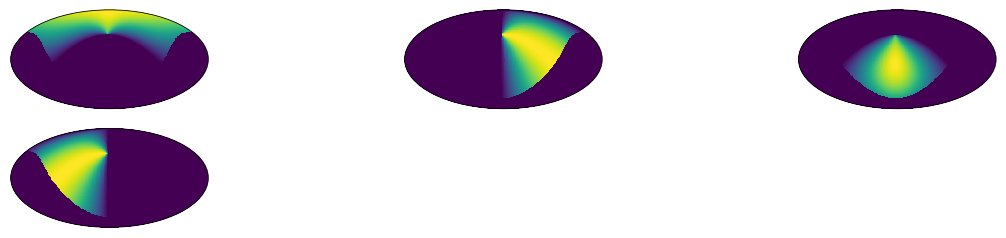

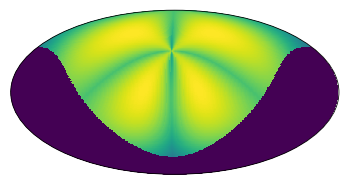

In [33]:
## Plot BurstCube Exposure maps

plot.figure(figsize=(20,len(pointings)))
x,y = (rr-180.)*np.pi/180.,dd*np.pi/180.
for sp in range(len(pointings)):
    m=plot.subplot(2, len(pointings)/2+1, sp+1, projection="mollweide")
    m.axes.xaxis.set_ticklabels([])
    m.axes.yaxis.set_ticklabels([])
    m.pcolormesh(x,y,exposures[sp].reshape((res,res)))
plot.show()

plot.figure(figsize=(20,20))
m=plot.subplot(2, len(pointings)/2+1, sp+1, projection="mollweide")
m.axes.xaxis.set_ticklabels([])
m.axes.yaxis.set_ticklabels([])
m.pcolormesh(x,y,exposures.sum(axis=0).reshape((res,res)))
plot.show()

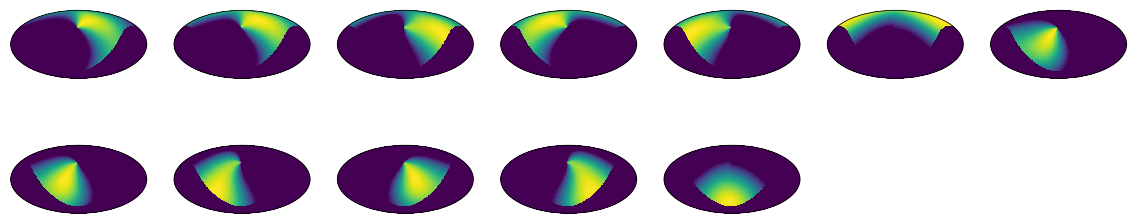

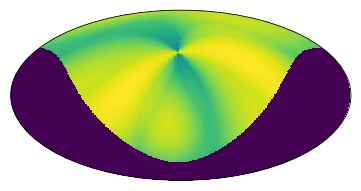

In [34]:
## plot GBM exposure maps

plot.figure(figsize=(20,len(gbm_pointings)))
x,y = (rr-180.)*np.pi/180.,dd*np.pi/180.
for sp in range(len(gbm_pointings)):
    m=plot.subplot(5, len(gbm_pointings)/2+1, sp+1, projection="mollweide")
    m.axes.xaxis.set_ticklabels([])
    m.axes.yaxis.set_ticklabels([])
    m.pcolormesh(x,y,gbm_exposures[sp].reshape((res,res)))
plot.show()

plot.figure(figsize=(50,50))
m=plot.subplot(2, len(gbm_pointings)/2+1, sp+1, projection="mollweide")
m.axes.xaxis.set_ticklabels([])
m.axes.yaxis.set_ticklabels([])
m.pcolormesh(x,y,gbm_exposures.sum(axis=0).reshape((res,res)))
# ra,dec=random_sky(1000)
# ra=np.radians(np.array(ra)-180)
# dec=np.radians(np.array(dec))
# inside=np.where(separation(np.degrees(ra),np.degrees(dec),0,35)<=100.)[0]
# m.plot(ra,dec,marker='o',linestyle='None')
# m.plot(ra[inside],dec[inside],marker='o',linestyle='None')

plot.show()

In [35]:
def separation(ra1,dec1,ra2,dec2):

    c=SkyCoord(ra=ra1*u.deg,dec=dec1*u.deg)
    d=SkyCoord(ra=ra2*u.deg,dec=dec2*u.deg)
    dist=c.separation(d)
    dist=dist.value

    return dist

In [50]:
def throw_grbs(spacecraft,fermi,Aratio,minflux,maxflux,pf):
    
    ## exposures from above
    ## exposure_positions from above
    ## Aratio for particular BC config or 1 for GBM
    ## minflux/maxflux is min/max flux from GBM
    nsims=int(np.round(len(pf)*2))
    ra,dec=random_sky(nsims)
    ra=np.array(ra)-180
    dec=np.array(dec)
    #sigma=0.65,mean=1.5
    
#    was getting error in print statement below that t was not defined. Commented out the below line and it worked.
   # popt,pcov=curve_fit(lambda t,a: fmodel['pow'](t,a,b),t,rate) 
    flux=np.random.lognormal(size=nsims,sigma=0.6,mean=0.6)*(np.log10(maxflux)-np.log10(minflux))+np.log10(minflux)
#    flux=10**flux
#    print min(flux),max(flux)
#    plot.plot()
#    plot.hist(flux,bins=np.logspace(-1,2,30))
#    plot.xscale('log')
#    plot.show()
#    print len(exposure_positions[0]),len(exposure_positions[1]),len(exposures)
#    expradec=loginterpol2d(exposure_positions[0],exposure_positions[1],exposures,ra,dec)
    randexposures = np.array([[detector.exposure(ra[i],dec[i]) for i in range(nsims)] for detector in spacecraft.detectors])
    randgbmexposures = np.array([[detector.exposure(ra[i],dec[i]) for i in range(nsims)] for detector in fermi.detectors])

    BCsens = minflux/Aratio/np.array(randexposures.max(axis=0))
    GBMsens = minflux/np.array(randgbmexposures.max(axis=0))

#     inside=np.where(separation(ra,dec,0,35)<100.)[0]
#     ninside=len(inside)
#     print ninside
    w=np.where(flux-BCsens>0)[0]
    bcdetfrac=float(len(w))/nsims

    wg=np.where(flux-GBMsens>0)[0]
    gbmdetfrac=float(len(wg))/nsims
    if j ==0:
#         plot.figure()
#         plot.plot(ra,dec,marker='o',linestyle='None')
#         plot.plot(ra[inside],dec[inside],marker='o',linestyle='None')
#         plot.show()
        
        fig=plot.figure(figsize=(20,5))
        plot.subplot(1,2,1)
        plot.hist(pf,label='real GBM',bins=np.logspace(-1,2,40))
        plot.hist(flux[wg],label='GBM',bins=np.logspace(-1,2,40),alpha=0.7)
        plot.xscale('log')
        plot.legend()
        plot.subplot(1,2,2)
        plot.hist(flux,label='All',bins=np.logspace(-1,2,40))
        plot.hist(pf,label='real GBM',bins=np.logspace(-1,2,40))
        plot.hist(flux[wg],label='GBM',bins=np.logspace(-1,2,40),alpha=0.7)
        plot.hist(flux[w],label='BC',bins=np.logspace(-1,2,40),alpha=0.7)
        plot.xscale('log')
        plot.legend()

        plot.show()
        
    return bcdetfrac,gbmdetfrac,BCsens,GBMsens

/home/alyson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/home/alyson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


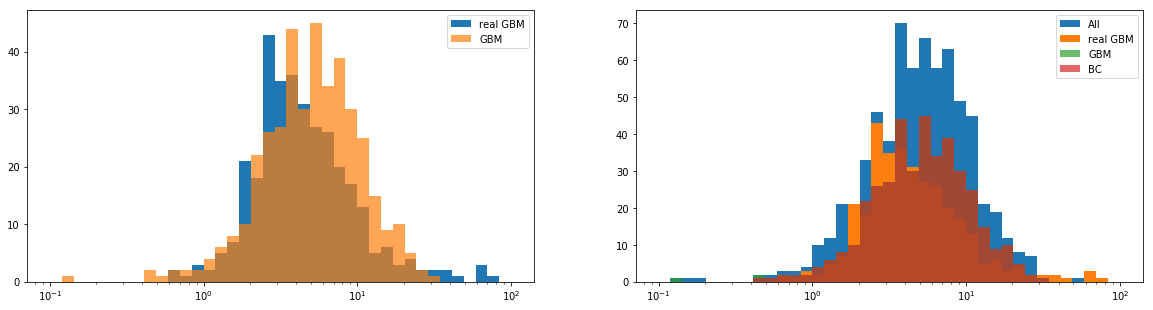

0 0.59 0.59 1.0 0.32 0.08 0.25 39.3
1 0.59 0.59 0.99 0.31 0.08 0.26 39.2
2 0.56 0.56 1.0 0.31 0.08 0.26 39.4
3 0.6 0.61 0.99 0.31 0.08 0.26 39.0
4 0.6 0.6 1.0 0.3 0.08 0.26 39.5
5 0.56 0.56 0.99 0.3 0.08 0.26 39.3
6 0.59 0.59 1.0 0.3 0.08 0.26 39.4
7 0.6 0.6 1.0 0.29 0.08 0.27 39.3
8 0.6 0.6 0.99 0.29 0.08 0.27 39.1
9 0.59 0.59 1.0 0.29 0.08 0.27 39.5
10 0.58 0.58 0.99 0.29 0.08 0.27 39.3
11 0.61 0.62 1.0 0.29 0.08 0.27 39.3
12 0.59 0.59 1.0 0.29 0.08 0.27 39.5
13 0.6 0.6 1.0 0.36 0.08 0.22 39.3
14 0.59 0.59 0.99 0.36 0.08 0.22 39.3
15 0.58 0.58 0.99 0.36 0.08 0.22 39.3
16 0.56 0.56 0.99 0.36 0.08 0.22 39.3
17 0.59 0.59 0.99 0.36 0.08 0.22 39.1
18 0.56 0.57 0.99 0.36 0.08 0.22 39.3
19 0.57 0.58 0.99 0.34 0.08 0.23 39.1
20 0.59 0.59 1.0 0.34 0.08 0.23 39.5
21 0.58 0.58 1.0 0.34 0.08 0.23 39.4
22 0.6 0.6 0.99 0.34 0.08 0.23 39.2
23 0.58 0.59 0.98 0.34 0.08 0.23 38.9
24 0.57 0.57 0.99 0.34 0.08 0.23 39.2
25 0.59 0.59 0.99 0.32 0.08 0.24 39.1
26 0.61 0.62 0.99 0.32 0.08 0.24 38.9
27 0.61 0

In [54]:
flux=gbm['FLUX_BATSE_64'][s]
minflux=min(flux)
maxflux=max(flux)
for j in range(len(w)-1):
#    j=0 # which BC config
    w=np.where(engdiff<0)[0]
    w=np.append(-1,w)

    outE=np.logspace(np.log10(50),np.log10(300),20)
    AeffBC=np.mean(loginterpol(aeffs['keV'][w[j]+1:w[j+1]+1],aeffs['aeff'][w[j]+1:w[j+1]+1],outE))
    AeffGBM=np.mean(loginterpol(aeff_gbm['energy'],aeff_gbm['aeff'],outE))
    Aratio=np.sqrt(AeffBC/AeffGBM)
    BCdetfrac,GBMdetfrac,BCsens,GBMsens=throw_grbs(spacecraft,fermi,Aratio,minflux,maxflux,flux)
    print(j,np.round(BCdetfrac,2),np.round(GBMdetfrac,2),np.round(BCdetfrac/GBMdetfrac,2),np.round(np.min(BCsens),2),\
    np.round(np.min(GBMsens),2),np.round(np.min(GBMsens)/np.min(BCsens),2),np.round(BCdetfrac/GBMdetfrac*rate,1))


BCsens = np.min(sflux)/Aratio/np.array(exposures.max(axis=0))
GBMsens = np.min(sflux)/np.array(gbm_exposures.max(axis=0))
plot.hist(BCsens[BCsens<5])
plot.show()
print np.min(sflux)
print np.min(BCsens),np.min(GBMsens)